**1. Install** Gdown for datasets importation from the google drive folder and PEFT for LORA fine tuning

In [1]:
!pip install peft
!pip install gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.9/504.9 kB 18.4 MB/s eta 0:00:00


**2.** Importing relevant libraries, Model name given is distilBERT-base-Multilingual-Cased and can be gotten at <https://huggingface.co/distilbert/distilbert-base-multilingual-cased> which is smaller version of the BERT multilingual cased. The Epochs that we start training are 3, which is the standard for huge datasets like the ones we are utilising. A smaller learning rate of 0.00001 is applied to prevent overfitting and also improve convergence as the model moves closer to a local minima. A batch size of 32 is utilised where the dataset is processed in batches of 32 , the batch technique that makes this feasible to do is mini batch gradient descent.

In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import gdown
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import os
import math


MODEL_NAME = 'distilbert-base-multilingual-cased'
OUTPUT_DIR = './distilbert-multilingual-hate-speech-classifier-lora'
NUM_TRAIN_EPOCHS = 3
BATCH_SIZE = 32
LEARNING_RATE = 0.00001
TEST_SPLIT_SIZE = 0.2  # 20% for testing
VALIDATION_SPLIT_SIZE = 0.2  # 20% for validation

# Datasets in CSV file
GDRIVE_FILE_IDS = [
    '1xKOiSCN6nz-u-a6N6L8H1qOkds1LkHT_', '1OYhGuFDYLFOtNPeul1cN4U2xDNTt72Fp',
    '1ndVQFbv9OAtfwPnovthJbx_7_vk-ttei', '1WqcpUsRgCSxFB7m4JTXQEDwhm3ZqqbJn',
    '1KNAU4yvk42EZHmq8JneA6HoaL62rFzb7', '1yeEm6Y5-4arroGxJlIDXdX9tzUM970_r',
    '1c8kMDx_s8ODeAZYjZPIaVNtVQlGRLY_5', '1BxMVfrrrwvt7aIZ8nXpQ67BAggvvE0d7',
    '1adMpQLOCpebd0T11GjdT_f3pxcX8FLy5', '1kmB4JfZAVmKyCXs1GZa_STXYIOYllNld',
]

CSV_FILENAMES = [
    "de_hf_112024.csv", "ar_hf_112024.csv", "en_hf_112024.csv",
    "es_hf_102024.csv", "fr_hf_112024.csv", "in_hf_112024.csv",
    "india_hf.csv", "kenya_hf.csv", "pt_hf_112024.csv", "tr_hf_112024.csv"
]


# Print the list of file IDs that will be processed.
print("Model_Logistics_Summary ")
print(f"Model to be trained: {MODEL_NAME}")
print(f"Number of Google Drive files to download: {len(GDRIVE_FILE_IDS)}")
print("CSV_Files downloaded:")
for fid, fname in zip(GDRIVE_FILE_IDS, CSV_FILENAMES):
    print(f"  - ID: {fid} -> Filename: {fname}")


/usr/local/lib/python3.12/dist-packages/torch_xla/experimental/gru.py:113: SyntaxWarning: invalid escape sequence '\_'
  * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or
/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Model_Logistics_Summary 
Model to be trained: distilbert-base-multilingual-cased
Number of Google Drive files to download: 10
CSV_Files downloaded:
  - ID: 1xKOiSCN6nz-u-a6N6L8H1qOkds1LkHT_ -> Filename: de_hf_112024.csv
  - ID: 1OYhGuFDYLFOtNPeul1cN4U2xDNTt72Fp -> Filename: ar_hf_112024.csv
  - ID: 1ndVQFbv9OAtfwPnovthJbx_7_vk-ttei -> Filename: en_hf_112024.csv
  - ID: 1WqcpUsRgCSxFB7m4JTXQEDwhm3ZqqbJn -> Filename: es_hf_102024.csv
  - ID: 1KNAU4yvk42EZHmq8JneA6HoaL62rFzb7 -> Filename: fr_hf_112024.csv
  - ID: 1yeEm6Y5-4arroGxJlIDXdX9tzUM970_r -> Filename: in_hf_112024.csv
  - ID: 1c8kMDx_s8ODeAZYjZPIaVNtVQlGRLY_5 -> Filename: india_hf.csv
  - ID: 1BxMVfrrrwvt7aIZ8nXpQ67BAggvvE0d7 -> Filename: kenya_hf.csv
  - ID: 1adMpQLOCpebd0T11GjdT_f3pxcX8FLy5 -> Filename: pt_hf_112024.csv
  - ID: 1kmB4JfZAVmKyCXs1GZa_STXYIOYllNld -> Filename: tr_hf_112024.csv


**3.** Since this model was developed on Google Colab pro, it was important to take advantage of the GPU's availabe. We then download the datasets from the Google drive public folder, the arabic dataset, gets flagged as a buffer overflow. So only nine datasets will actually be used. Data cleaning happens in 3 stages, first stage is select and keep columns that we feel are necessary to our use case which are text, labels, source, dataset and post_author_country_location, second stage is to drop rows with missing text and labels, stage 3 is to convert existing text data into lowercase. Data splitting is done randomly and stratified to prevent leakages. A 60 percent is allocated to Train sample split, 20 percent to Validate sample Split and 20 percent on Test sample split.

In [3]:
# Important because of the GPU's and TPU's available on google colab
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

if not GDRIVE_FILE_IDS:
    raise ValueError("The 'GDRIVE_FILE_IDS' list in Cell 1 is empty.")
if len(GDRIVE_FILE_IDS) != len(CSV_FILENAMES):
    raise ValueError("The number of file IDs must match the number of filenames.")

print(f"Preparing to download {len(GDRIVE_FILE_IDS)} CSV files from Google Drive.")
df_list = []
for file_id, filename in zip(GDRIVE_FILE_IDS, CSV_FILENAMES):
    try:
        gdown.download(id=file_id, output=filename, quiet=False)
        df_list.append(pd.read_csv(filename, on_bad_lines='skip'))
    except Exception as e:
        print(f"Could not process file {filename} (ID: {file_id}). Error: {e}. Skipping file.")

df = pd.concat(df_list, ignore_index=True)

# Data Cleaning
print("\nData Cleaning")
# 1. Stage 1 select and keep only the necessary columns that we feel suit our use case.
columns_to_keep = ['text', 'labels', 'source', 'dataset', 'post_author_country_location']
# countercheck to see if the desired columns actually exist in order to avoid Errors.
existing_columns_to_keep = [col for col in columns_to_keep if col in df.columns]
df = df[existing_columns_to_keep]
print(f"Selected relevant columns. New shape: {df.shape}")
print(f"Columns kept: {df.columns.tolist()}")

# 2. Drop rows with missing text or labels
df.dropna(subset=['text', 'labels'], inplace=True)
print(f"Shape after dropping nulls: {df.shape}")

# 3. Converting data in text column to lowercase.
df['text'] = df['text'].str.lower()
print(" Converting data in text column to lowercase.")
print("\nFinished loading, combining, and cleaning all data.")
print("Total number of examples:", len(df))

# Dictionary translators for the model, the datasets contains the 0 for not hateful and 1 for hateful so this is just making things readable.
id2label = {0: "Not Hateful", 1: "Hateful"}
label2id = {"Not Hateful": 0, "Hateful": 1}
num_labels = 2

# Data splitted into 60 percent train, 20 percent validate and 20 percent test and stratified to prevent leakages.
df_train_val, df_test = train_test_split(df, test_size=TEST_SPLIT_SIZE, random_state=42, stratify=df['labels'])
val_proportion = VALIDATION_SPLIT_SIZE / (1.0 - TEST_SPLIT_SIZE)
df_train, df_val = train_test_split(df_train_val, test_size=val_proportion, random_state=42, stratify=df_train_val['labels'])

print("\nData splitting complete:")
print(f"Training set size:   {len(df_train)} examples")
print(f"Validation set size: {len(df_val)} examples")
print(f"Test set size:       {len(df_test)} examples")

Using device: cpu
Preparing to download 10 CSV files from Google Drive.


Downloading...
From: https://drive.google.com/uc?id=1xKOiSCN6nz-u-a6N6L8H1qOkds1LkHT_
To: /content/de_hf_112024.csv
100%|██████████| 76.3M/76.3M [00:00<00:00, 242MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OYhGuFDYLFOtNPeul1cN4U2xDNTt72Fp
To: /content/ar_hf_112024.csv
100%|██████████| 11.1M/11.1M [00:00<00:00, 193MB/s]


Could not process file ar_hf_112024.csv (ID: 1OYhGuFDYLFOtNPeul1cN4U2xDNTt72Fp). Error: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.
. Skipping file.


Downloading...
From: https://drive.google.com/uc?id=1ndVQFbv9OAtfwPnovthJbx_7_vk-ttei
To: /content/en_hf_112024.csv
100%|██████████| 68.0M/68.0M [00:00<00:00, 144MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WqcpUsRgCSxFB7m4JTXQEDwhm3ZqqbJn
To: /content/es_hf_102024.csv
100%|██████████| 5.34M/5.34M [00:00<00:00, 145MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KNAU4yvk42EZHmq8JneA6HoaL62rFzb7
To: /content/fr_hf_112024.csv
100%|██████████| 2.76M/2.76M [00:00<00:00, 366MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yeEm6Y5-4arroGxJlIDXdX9tzUM970_r
To: /content/in_hf_112024.csv
100%|██████████| 2.01M/2.01M [00:00<00:00, 385MB/s]
Downloading...
From: https://drive.google.com/uc?id=1c8kMDx_s8ODeAZYjZPIaVNtVQlGRLY_5
To: /content/india_hf.csv
100%|██████████| 5.72M/5.72M [00:00<00:00, 177MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BxMVfrrrwvt7aIZ8nXpQ67BAggvvE0d7
To: /content/kenya_hf.csv
100%|██████████| 6.67M/6.67M [00:00<00:00, 116MB/s]



Data Cleaning
Selected relevant columns. New shape: (1018679, 5)
Columns kept: ['text', 'labels', 'source', 'dataset', 'post_author_country_location']
Shape after dropping nulls: (1018678, 5)
 Converting data in text column to lowercase.

Finished loading, combining, and cleaning all data.
Total number of examples: 1018678

Data splitting complete:
Training set size:   611206 examples
Validation set size: 203736 examples
Test set size:       203736 examples


**4.** A pytorch Class dataloader is necessary for data loading

In [4]:
class HateSpeechDataset(Dataset):
    """
    We create this PyTorch dataloader which has the following defined functions:
    __Init__ which is the constructor function in this class
    __len__ which returns the length of the datasets we preloaded from google drive.
    __getitem__ which retrieves individual observations.

    """
    def __init__(self, dataframe, tokenizer, max_length=128):

        self.tokenizer = tokenizer
        self.max_length = max_length
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['labels'].tolist()
        print(f"Initialized dataset with {len(self.texts)} examples.")

    def __len__(self):

        return len(self.texts)

    def __getitem__(self, idx):

        encoding = self.tokenizer(
            str(self.texts[idx]),
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        # tensors are compressed to remove unnecessary dimensions
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

class CustomTrainer(Trainer):
    """
    Adding a Custom trainer class to handle a version incompatibility;
    where 'num_items_in_batch'is passed to compute_loss,
    the model's forward pass does not expect it in some library versions.
    """
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # We accept num_items_in_batch to match the caller's signature,
        # but we don't pass it to the parent's compute_loss, which it doesn't expect.
        return super().compute_loss(model, inputs, return_outputs)

def compute_metrics(pred):
    labels = pred.label_ids
    # The PEFT model might return logits as a tuple, so we access the first element.
    preds_logits = pred.predictions[0] if isinstance(pred.predictions, tuple) else pred.predictions
    preds = np.argmax(preds_logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

def print_trainable_parameters(model):

    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

print("Helper classes and functions defined.")


Helper classes and functions defined.


**5.** Tokenizer and cleaned Pytorch datasets get instantiated by this block of code.

In [5]:
print(f"\n--- Preparing for Model: {MODEL_NAME} ---")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print("\nCreating PyTorch datasets...")
train_dataset = HateSpeechDataset(dataframe=df_train, tokenizer=tokenizer)
val_dataset = HateSpeechDataset(dataframe=df_val, tokenizer=tokenizer)
test_dataset = HateSpeechDataset(dataframe=df_test, tokenizer=tokenizer)


--- Preparing for Model: distilbert-base-multilingual-cased ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]


Creating PyTorch datasets...
Initialized dataset with 611206 examples.
Initialized dataset with 203736 examples.
Initialized dataset with 203736 examples.


**6.** **LORA parameter efficient tuning** this is done to finetune our distillbert model and reduce computational overhead. Instead of a full fine tuning we just train 15% of the original parameters and this gets us just a closer performance if it happened that we performed a full fine tuning.

In [6]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    target_modules=["q_lin", "v_lin"],
)

model = get_peft_model(model, lora_config)
print("\nModel configured with LoRA. Trainable parameters:")
print_trainable_parameters(model)

# We define steps per epoch for logging, evaluation, and saving
steps_per_epoch = math.ceil(len(train_dataset) / BATCH_SIZE)

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_distilbert_lora',
    logging_steps=steps_per_epoch,
    save_steps=steps_per_epoch,
    optim="adamw_torch",
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("\nStarting training...")
trainer.train()
print("Training finished.")

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model configured with LoRA. Trainable parameters:
trainable params: 887042 || all params: 136213252 || trainable%: 0.65

Starting training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training finished.


**7.** Evaluate on Test Data

In [7]:
print("\n--- Final Model Evaluation Report ---")
print("Generating final report on the 20% held-out Test set...")

# Critical part to perform a single, efficient pass on the Test Set to get all results
predictions = trainer.predict(test_dataset)

# The metrics are pre-computed by .predict() when a compute_metrics function is provided.
test_metrics = predictions.metrics
results_df = pd.DataFrame([test_metrics])
results_df = results_df[['test_loss', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall']]
results_df.columns = ['Loss', 'Accuracy', 'F1-Score', 'Precision', 'Recall']

print("\n--- Final Performance on Test Set (Official Score) ---")
print(results_df.round(4).to_string(index=False))


--- Final Model Evaluation Report ---
Generating final report on the 20% held-out Test set...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Final Performance on Test Set (Official Score) ---
  Loss  Accuracy  F1-Score  Precision  Recall
0.2868    0.8821    0.8679     0.8686  0.8821


**8.** Results Visualization


 Confusion Matrix 


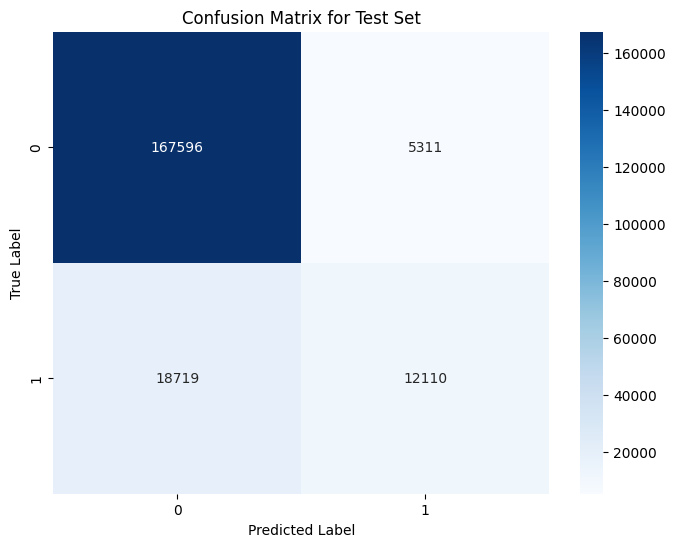


--- Misclassification Examples ---

--- False Positives (Predicted 'Hateful', but was 'Not Hateful') ---
Example 1:
  Text: #québec #harcèlement #agressions  #moiaussi #metoo: 25 millions de dollars sont  débloqués : comme quoi la vague de #balancetonporc réveille et il était temps  information.tv5monde.com/terriennes/les…...
--------------------
Example 2:
  Text: @user apa nggak malu kamu pake nama muslim tapi kamu memprovokasi orang, mengajak orang lain membenci.. manfaatnya apa untuk orang lain? lebih baik menyebarkan berita yang bermanfaat.....
--------------------
Example 3:
  Text: but about to bring all the ghetto ass shit uptoen 😝 😝 😝...
--------------------
Example 4:
  Text: @user tienda of course they would say that. but they have been wanting to wipe israel and the us off the map since the day they got in power. we don't want genocide, they do. the iranians used lines o...
--------------------
Example 5:
  Text: alevi gelin isteyen anneme sunni damat şoku...
-------------

In [8]:
raw_predictions = predictions.predictions
logits = raw_predictions[0] if isinstance(raw_predictions, tuple) else raw_predictions
y_pred = np.argmax(logits, axis=1)
y_true = predictions.label_ids

print("\n Confusion Matrix ")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label2id.values(), yticklabels=label2id.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Misclassification Examples
print("\n--- Misclassification Examples ---")
df_test_reset = df_test.reset_index(drop=True)

# False positives, texts that were predicted hateful and were not.
fp_indices = np.where((y_pred == 1) & (y_true == 0))[0]
print("\n--- False Positives (Predicted 'Hateful', but was 'Not Hateful') ---")
for i, idx in enumerate(fp_indices[:5]): # Show first 5
    print(f"Example {i+1}:")
    print(f"  Text: {df_test_reset.iloc[idx]['text'][:200]}...")
    print("-" * 20)

# False negatives, texts that were predicted not hateful but were hateful.
fn_indices = np.where((y_pred == 0) & (y_true == 1))[0]
print("\n--- False Negatives (Predicted 'Not Hateful', but was 'Hateful') ---")
for i, idx in enumerate(fn_indices[:5]): # Show first 5
    print(f"Example {i+1}:")
    print(f"  Text: {df_test_reset.iloc[idx]['text'][:200]}...")
    print("-" * 20)


**9.** Save Model

In [9]:
final_model_path = f"{OUTPUT_DIR}/final"
trainer.save_model(final_model_path)
print(f"\nValidated model saved to {final_model_path}")



Validated model saved to ./distilbert-multilingual-hate-speech-classifier-lora/final
